# Autoregression Model Comparison

### Imports and Load data from 1965

In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")

# Memory control
physical_devices = tf.config.list_logical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading data
def load_dfs(save_dir='data_export'):

    g20_path = os.path.join(save_dir, 'g20_df_1965.pkl')
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')

    try:
        g20_df = pd.read_pickle(g20_path)
        print(f"Successfully loaded g20 dataframe pickle file")
        lag_df = pd.read_pickle(lag_path)
        print(f"Successfully loaded time lagged g20 dataframe pickle file")

        return g20_df, lag_df

    except FileNotFoundError as e:
        print(f"Error in loading pickle files: {e}")

        try:
            g20_csv = g20_path.replace('.pkl', '.csv')
            lag_csv = lag_path.replace('.pkl', '.csv')

            g20_df = pd.read_csv(g20_csv)
            print(f"Successfully loaded g20 dataframe csv file")
            lag_df = pd.read_csv(lag_csv)
            print(f"Successfully loaded time lagged g20 dataframe csv file")

            return g20_df, lag_df

        except FileNotFoundError as e:
            print(f"Error in loading csv files: {e}")
            return None, None

In [2]:
g20_df, lag_df = load_dfs()

Successfully loaded g20 dataframe pickle file
Successfully loaded time lagged g20 dataframe pickle file


In [3]:
# Config
target_variables = ['co2', 'gdp', 'primary_energy_consumption']
n_steps_in = 5
n_steps_out = 3
g20_countries = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

### Utility Functions

In [4]:
# Optimised memory
def clear_memory():

    tf.keras.backend.clear_session()
    gc.collect()

    if len(tf.config.list_physical_devices('GPU')) > 0:
        tf.config.experimental.reset_memory_stats('GPU:0')

In [5]:
# Function for RMSE
def rmse(pred, actual):
    return np.sqrt(((pred - actual)**2).mean())

In [6]:
# Function for MASE
def mase(actual, pred, period=1):
    """
    MASE = MAE / naive_forecast_MAE(average magnitude of errors)
    """

    # MAE of prediction
    mae_forecast = mean_absolute_error(actual, pred)

    # MAE of naive forecast with previous period
    naive_forecast = actual[:-period] if period > 0 else actual[:-1]
    actual_for_naive = actual[period:] if period > 0 else actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

### Data Preperation and Functions

In [7]:
# Data scale information
def get_target_info(target_var):

    scale_info = {
        # CO2 is already in millions
        'co2': {
            'unit': 'Million tonnes CO2',
            'scale_factor': 1,
            'log_transform': False
        },
        # Convert to trillions, log_transform is highly skewed
        'gdp': {
            'unit': 'Trillion USD',
            'scale_factor': 1e-12,
            'log_transform': True
        },
        # Convert to thousands of TWh
        'primary_energy_consumption': {
            'unit': 'Thousand TWh',
            'scale_factor': 1e-3,
            'log_transform': False
        }
    }

    return scale_info.get(target_var, {'unit': 'Original', 'scale_factor': 1, 'log_transform': False})

In [8]:
# Scale target
def scale_target_data(data, target_var):

    scale_info = get_target_info(target_var)

    scaled_data = data * scale_info['scale_factor']

    if scale_info['log_transform']:
        scaled_data = np.log1p(np.maximum(scaled_data, 1e-10))

    return scaled_data, scale_info

In [ ]:
# Inverse scale target
def inverse_scale_target(scaled_data, scale_info):

    data = scaled_data.copy()

    # When log_transform is True
    if scale_info['log_transform']:
        data = np.expm1(data)

    data = data / scale_info['scale_factor']

    return data

In [10]:
# Preparing Autoregression data
def prepare_ar_data(country, target_var, lag_df, n_steps_in=5):
    """
    n_steps_in=5 : current value + 4 lags
    """

    print(f"\nPreparing Autoregressive datafor {country}: {target_var}")

    # Country data from lag_df
    country_data = lag_df[lag_df['country'] == country].copy()
    country_data = country_data.sort_values('year')

    # Columns: target + 4 lags
    feature_cols = [target_var]
    for i in range(1, n_steps_in):
        lag_col = f"{target_var}_lag{i}"
        if lag_col in country_data.columns:
            feature_cols.append(lag_col)
        else:
            print(f"No {lag_col} for {country}")
        
    # Extract data and remove na
    data_subset = country_data[['year'] + feature_cols].copy()
    data_subset = data_subset.dropna()

    years = data_subset['year'].values

    # Scale target for RMSE
    scale_info = get_target_info(target_var)

    scaled_features = []
    for col in feature_cols:
        scaled_col, _ = scale_target_data(data_subset[col].values, target_var)
        scaled_features.append(scaled_col)

    ar_data = np.column_stack(scaled_features)
    target_values = scaled_features[0]

    print(f"Features used: {feature_cols}")
    print(f"Data shape: {ar_data.shape}")
    print(f"Scale info: {scale_info['unit']}, Log transform: {scale_info['log_transform']}")
    print(f"Scaled range: {np.min(target_values):.2f} - {np.max(target_values):.2f}")

    return ar_data, years, target_values, feature_cols, scale_info

In [11]:
# Create sequences to make it 3 steps out
def create_seq_for_pred(ar_data, n_steps_out=3):
    """
    [t-4, t-3, t-2, t-1, t] -> [t+1, t+2, t+3]
    """

    X, y = [], []
    
    for i in range(len(ar_data) - n_steps_out):
        # [t, t-1, t-2, t-3, t-4]: Shape (5,)
        X_seq = ar_data[i]
        
        # [t+1, t+2, t+3]
        y_seq = []
        for j in range(1, n_steps_out + 1):

            if i + j < len(ar_data):
                # First column is the target
                y_seq.append(ar_data[i + j, 0])
            else:
                break
            
        if len(y_seq) == n_steps_out:
            X.append(X_seq)
            y.append(y_seq)

    # Shape (n_samples, 5)
    X = np.array(X)
    # Shape (n_samples, 3)
    y = np.array(y)

    return X, y

In [ ]:
# Preparing data for DL to handle 3D inputs and scaling
def prepare_dl_data(X, y):

    """X_transformed = np.log1p(np.abs(X))
    y_transformed = np.log1p(np.abs(y))
    Xscaler = MinMaxScaler(feature_range=(-1, 1))
    yscaler = MinMaxScaler(feature_range=(-1, 1))
    X_tfed = Xscaler.fit_transform(X_transformed)
    y_tfed = yscaler.fit_transform(y_transformed)"""
    
    # Shape (n_samples, 5, 1)

    # Scaler (2D)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # (n_samples, 5)
    X_scaled = X_scaler.fit_transform(X)
    # (n_samples, 3)
    y_scaled = y_scaler.fit_transform(y)

    X_dl_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

    return X_dl_scaled, y_scaled, X_scaler, y_scaler

In [13]:
### Is Relative RMSE going to be needed??

### Constructing Models

In [ ]:
# Tuning ARIMA - AIC criterion
def tune_arima_params(data, max_p=4, max_d=2, max_q=3):
    """
    p (autoregressive order): num of lag obs to include
    d (differencing degree): num of time data different to make it stationary
    q (moving avg order): size of moving avg window
    Lower AIC -> better model fit
    """

    best_aic = np.inf
    best_params = None
    best_model = None

    # Testing stationarity
    result = adfuller(data)
    max_d = 1 if result[1] <= 0.05 else 2

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                    
                except:
                    continue
    
    print(f"Best ARIMA params: {best_params}, AIC: {best_aic:.2f}")

    return best_model, best_params, best_aic

In [ ]:
# Tuning VAR 
# -> it might cause overfitting since there are too less tranining samples compared to the number of features
def tune_var_params(data, max_lags=4):
    """
    Each variable is modeled as linear of past values of itself (other variables but not for this data)
    lag_order -> num of lag periods to include
    using AIC to select optimal lag order.
    """

    model = VAR(data)
    lag_order = model.select_order(maxlags=max_lags)
    best_lag = lag_order.aic
    print(f"Best VAR lag order: {best_lag}")
    
    fitted_model = model.fit(best_lag)

    return fitted_model, best_lag

In [16]:
# Autoregressive vanilla LSTM
def build_ar_lstm(input_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape,
             kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [17]:
# Autoregressive Bidirectional LSTM
def build_ar_bilstm(input_shape, hidden=8):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
                       input_shape=input_shape),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [18]:
# Autoregressive Encoder-Decoder LSTM
def build_ar_edlstm(input_shape, hidden=8):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        RepeatVector(n_steps_out),
        LSTM(hidden, activation='relu', return_sequences=True,
             kernel_regularizer=l2(0.001)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

In [19]:
# Autoregressive CNN
def build_ar_cnn(input_shape, filters=32, hidden=8):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same',
               kernel_regularizer=l2(0.001)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

### Model training and evaluation functions

In [20]:
# Training ARIMA
def train_arima_model(X_train, y_train, X_test, y_test):

    try:
        # Using first column of the target (1D)
        target_train = X_train[:, 0]

        model, params, aic = tune_arima_params(target_train)

        preds = []

        # Forecasting len(y_test) steps
        for i in range(len(y_test)):
            try:
                # Forecasting 1 step
                forecast_result = model.forecast(steps=1)
                # Check if its not a sequence (array, list, pandas Series) 
                pred_value = forecast_result[0] if hasattr(forecast_result, '__len__') else forecast_result
                preds.append(pred_value)

                # Update the model with actual for the next pred
                if i < len(y_test) - 1:
                    actual_next = y_test[i, 0]
                    new_data = np.append(target_train, actual_next)
                    model = ARIMA(new_data, order=params).fit()
                    target_train = new_data

            except Exception as e:
                print(f"ARIMA pred step {i} failed {e}")
                preds.append(preds[-1] if preds else 0)

        preds = np.array(preds)
        actual_test = y_test[:, 0]

        rmse_score = rmse(preds, actual_test)
        mase_score = mase(actual_test, preds)

        return preds, rmse_score, mase_score

    except Exception as e:
        print(f"ARIMA training failed {e}")

        return None, None, None

In [21]:
# Training VAR
def train_var_model(X_train, y_train, X_test, y_test):

    try:
        # VAR is multivariate
        model, lag_order = tune_var_params(X_train)

        # Predict all steps at once
        # Recent obs for forecasting
        recent_data = X_train[-lag_order:]
        
        # Forecast
        forecast_result = model.forecast(recent_data, steps=len(y_test))
        preds = forecast_result[:, 0]
        actual = y_test[:, 0]

        # Metrics
        rmse_score = rmse(preds, actual)
        mase_score = mase(actual, preds)
        

        return preds, rmse_score, mase_score
    
    except Exception as e:
        print(f"VAR training failed {e}")
        return None, None, None

In [22]:
# Training DL models
def train_dl_model(model_build, X_train, y_train, X_val, y_val, X_test, y_test, model_name):

    try:
        # Prep data for dl
        X_train_dl, y_train_scaled, _, y_scaler = prepare_dl_data(X_train, y_train)
        X_val_dl, y_val_scaled, _, _ = prepare_dl_data(X_val, y_val)
        X_test_dl, _, _, _ = prepare_dl_data(X_test, y_test)

        # Build model
        # (Steps, n_features)
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        model = model_build(input_shape)

        early_stopping = EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.01
            )   # patience=15 since it a small dataset for each feature for each country
                # min_delta=0.01 for less striction

        # Calculate batch_size
        batch_size = min(8, len(X_train_dl))

        # Train model
        history = model.fit(
            X_train_dl, y_train_scaled,
            validation_data=(X_val_dl, y_val_scaled),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

        # Predict
        preds_scaled = model.predict(X_test_dl, verbose=0)

        # Handling ED-LSTM 3D output (batch, steps, 1)
        if len(preds_scaled.shape) == 3:
            preds_scaled = preds_scaled.reshape(preds_scaled.shape[0], preds_scaled.shape[1])

        preds = y_scaler.inverse_transform(preds_scaled)

        # First step preds
        pred_first = preds[:, 0]
        actual_first = y_test[:, 0]

        # Metrics
        rmse_score = rmse(pred_first, actual_first)
        mase_score = mase(actual_first, pred_first)

        # Memory
        del model, history, X_train_dl, y_train_scaled, X_val_dl, y_val_scaled, X_test_dl
        clear_memory()

        return pred_first, rmse_score, mase_score

    except Exception as e:
        print(f"{model_name} training failed {e}")
        clear_memory()
        return None, None, None

In [ ]:
# Training DL models for log transform
def train_dl_model_log(model_build, X_train, y_train, X_val, y_val, X_test, y_test, model_name):

    try:
        # If log transform can be applied
        data_range = np.max(y_train) - np.min(y_train)
        use_log = data_range > 1000

        print(f"Data range: {data_range:.2f}. Using log transform {use_log}")

        # Prep data for dl
        X_train_dl, y_train_scaled, _, y_scaler, transformed = prepare_dl_data(X_train, y_train, use_log_transform=use_log)
        X_val_dl, y_val_scaled, _, _, transformed = prepare_dl_data(X_val, y_val, use_log_transform=use_log)
        X_test_dl, _, _, _, transformed = prepare_dl_data(X_test, y_test, use_log_transform=use_log)

        # Build model
        # (Steps, n_features)
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        model = model_build(input_shape)

        early_stopping = EarlyStopping(
            monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.01
            )   # patience=15 since it a small dataset for each feature for each country
                # min_delta=0.01 for less striction

        # Calculate batch_size
        batch_size = min(8, len(X_train_dl))

        # Train model
        model.fit(
            X_train_dl, y_train_scaled,
            validation_data=(X_val_dl, y_val_scaled),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

        # Predict
        preds_scaled = model.predict(X_test_dl, verbose=0)

        # Handling ED-LSTM 3D output (batch, steps, 1)
        if len(preds_scaled.shape) == 3:
            preds_scaled = preds_scaled.reshape(preds_scaled.shape[0], preds_scaled.shape[1])

        preds = inverse_tf_preds(preds_scaled, y_scaler, transformed)

        # First step preds
        pred_first = preds[:, 0]
        actual_first = y_test[:, 0]

        # Metrics
        rmse_score = rmse(pred_first, actual_first)
        mase_score = mase(actual_first, pred_first)

        # Relative rmse
        relative_rmse = rmse_score / np.mean(np.abs(actual_first)) * 100
        print(f"Relative RMSE: {relative_rmse:.2f}%")

        # Memory
        del model
        tf.keras.backend.clear_session()
        gc.collect()

        return pred_first, rmse_score, mase_score

    except Exception as e:
        print(f"{model_name} training failed {e}")
        tf.keras.backend.clear_session()
        gc.collect()
        return None, None, None

### Testing Frameworks

In [23]:
def analyse_data(country, target_var, lag_df):

    ar_data, years, target_values, feature_cols, scale_info = prepare_ar_data(
        country, target_var, lag_df, n_steps_in
    )

    print(f"Data Range: {np.min(target_values):.2f} - {np.max(target_values):.2f}")
    print(f"Mean: {np.mean(target_values):.2f}")
    print(f"Std: {np.std(target_values):.2f}")
    
    if target_values[-1] > 2 * target_values[0]:
        print(f"consider log transformation")

    changes = np.diff(target_values)
    print(f"Avg yearly change: {np.mean(changes):.1f}")
    print(f"Max yearly change: {np.max(np.abs(changes)):.1f}")
    
    return {
        'range': np.max(target_values) - np.min(target_values),
        'mean': np.mean(target_values),
        'growth_factor': target_values[-1]/target_values[0],
        'max_change': np.max(np.abs(changes))
    }

In [ ]:
# Test country
def test_country_target(country, target_var, lag_df):

    print(f"Testing {country}: {target_var}")

    data_stats = analyse_data(country, target_var, lag_df)

    # Prepare data
    ar_data, years, target_values, feature_cols, scale_info = prepare_ar_data(
        country, target_var, lag_df, n_steps_in=5
    )

    # Seq for pred
    X, y = create_seq_for_pred(ar_data, n_steps_out)

    """
    feature_df = pd.DataFrame(ar_data, columns=feature_cols)

    try:    
        train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = shuffled_test_train_val(
                n_steps_in, n_steps_out, feature_df, test_size=0.2, val_size=0.1
            )
    except Exception as e:
        print(f"Error with shuffled_test_train_val {e}")
    """
    
    # Time series seq split
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    # Test years for plots
    test_start_idx = train_size + val_size
    test_years = years[test_start_idx:test_start_idx + len(X_test)]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    results = {}

    # Testing models
    model_configs = [
        ('ARIMA', lambda: train_arima_model(X_train, y_train, X_test, y_test)),
        ('VAR', lambda: train_var_model(X_train, y_train, X_test, y_test)),
        ('LSTM', lambda: train_dl_model(build_ar_lstm, X_train, y_train, X_val, y_val, X_test, y_test, 'LSTM')),
        ('Bi-LSTM', lambda: train_dl_model(build_ar_bilstm, X_train, y_train, X_val, y_val, X_test, y_test, 'Bi-LSTM')),
        ('ED-LSTM', lambda: train_dl_model(build_ar_edlstm, X_train, y_train, X_val, y_val, X_test, y_test, 'ED-LSTM')),
        ('CNN', lambda: train_dl_model(build_ar_cnn, X_train, y_train, X_val, y_val, X_test, y_test, 'CNN'))
    ]

    for model_name, train_func in model_configs:
        print(f"\nTraining {model_name}")

        preds, rmse_score, mase_score = train_func()

        if preds is not None:
            print(f"{model_name} - RMSE:{rmse_score:.4f}, MASE:{mase_score:.4f}")

            results[model_name] = {
                'predictions': preds,
                'rmse': rmse_score,
                'mase': mase_score,
                'actual': y_test[:, 0],
                'test_years': test_years,
                'scale_info': scale_info
            }
        else:
            print(f"{model_name} failed")

        clear_memory()

    return results

In [ ]:
# Test country with log transform
def test_country_target_log(country, target_var, lag_df):

    print(f"Testing {country}: {target_var}")

    data_stats = analyse_data(country, target_var, lag_df)

    # Prepare data
    ar_data, years, target_values, feature_cols = prepare_ar_data(
        country, target_var, lag_df, n_steps_in
    )

    # Seq for pred
    X, y = create_seq_for_pred(ar_data, n_steps_out)

    """
    feature_df = pd.DataFrame(ar_data, columns=feature_cols)

    try:    
        train, val, test, X_train, y_train, X_val, y_val, X_test, y_test = shuffled_test_train_val(
                n_steps_in, n_steps_out, feature_df, test_size=0.2, val_size=0.1
            )
    except Exception as e:
        print(f"Error with shuffled_test_train_val {e}")
    """
    # Time series seq split
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    results = {}

    # Testing models
    model_configs = [
        ('ARIMA', lambda: train_arima_model(X_train, y_train, X_test, y_test)),
        ('VAR', lambda: train_var_model(X_train, y_train, X_test, y_test)),
        ('LSTM', lambda: train_dl_model(build_ar_lstm, X_train, y_train, X_val, y_val, X_test, y_test, 'LSTM')),
        ('Bi-LSTM', lambda: train_dl_model(build_ar_bilstm, X_train, y_train, X_val, y_val, X_test, y_test, 'Bi-LSTM')),
        ('ED-LSTM', lambda: train_dl_model(build_ar_edlstm, X_train, y_train, X_val, y_val, X_test, y_test, 'ED-LSTM')),
        #('Simple-Dense', lambda: train_dl_model(build_ar_dense, X_train, y_train, X_val, y_val, X_test, y_test, 'Simple-Dense')),
        ('CNN', lambda: train_dl_model(build_ar_cnn, X_train, y_train, X_val, y_val, X_test, y_test, 'CNN'))
    ]

    for model_name, train_func in model_configs:
        print(f"\nTraining {model_name}")

        preds, rmse_score, mase_score = train_func()

        if preds is not None:
            relative_rmse = rmse_score / np.mean(np.abs(y_test[:, 0])) * 100
            print(f"{model_name} - RMSE:{rmse_score:.4f}, MASE:{mase_score:.4f}")

            results[model_name] = {
                'predictions': preds,
                'rmse': rmse_score,
                'mase': mase_score,
                'relative_rmse': relative_rmse,
                'actual': y_test[:, 0]
            }
        else:
            print(f"{model_name} failed")

    return results

### Running Tests

In [25]:
def run_all_tests():

    all_results = defaultdict(lambda: defaultdict(dict))
    summary_stats = defaultdict(lambda: defaultdict(list))

    for target_var in target_variables:
        print(f"\nTesting target: {target_var.upper()}")

        for country in g20_countries:
            country_results = test_country_target(country, target_var, lag_df)

            all_results[target_var][country] = country_results

            for model_name, metrics in country_results.items():
                summary_stats[target_var][model_name].append({
                    'country': country,
                    'rmse': metrics['rmse'],
                    'mase': metrics['mase'],
                    'scale_info': metrics['scale_info']
                })
                
        clear_memory()

    return all_results, summary_stats

In [26]:
all_results, summary_stats = run_all_tests()


Testing target: CO2
Testing United States: co2

Preparing Autoregressive datafor United States: co2
Features used: ['co2', 'co2_lag1', 'co2_lag2', 'co2_lag3', 'co2_lag4']
Data shape: (59, 5)
Scale info: Million tonnes CO2, Log transform: False
Scaled range: 3399.55 - 6132.18
Data Range: 3399.55 - 6132.18
Mean: 5091.87
Std: 650.04
Avg yearly change: 26.1
Max yearly change: 547.5

Preparing Autoregressive datafor United States: co2
Features used: ['co2', 'co2_lag1', 'co2_lag2', 'co2_lag3', 'co2_lag4']
Data shape: (59, 5)
Scale info: Million tonnes CO2, Log transform: False
Scaled range: 3399.55 - 6132.18
Train: 39, Val: 8, Test: 9

Training ARIMA
Best ARIMA params: (0, 2, 2), AIC: 472.78
ARIMA - RMSE:350.5722, MASE:1.5457


Training VAR
Best VAR lag order: 2
VAR - RMSE:776.6254, MASE:3.9068

Training LSTM
LSTM - RMSE:352.6004, MASE:1.6904

Training Bi-LSTM
Bi-LSTM - RMSE:457.1149, MASE:2.1795

Training ED-LSTM
ED-LSTM - RMSE:378.9167, MASE:1.8266

Training CNN
CNN - RMSE:597.1433, MASE:

### Results

In [27]:
def analyse_results(summary_stats, save_dir='data_export'):
    
    print("\nSummary Statistics")
    
    # Create save directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory created")

    summary_df_list = []
    
    for target_var in target_variables:
        scale_info = get_target_info(target_var)
        print(f"\n{target_var.upper()} Results (Unit: {scale_info['unit']})")
        
        for model_name in ['ARIMA', 'VAR', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']:
            if model_name in summary_stats[target_var] and summary_stats[target_var][model_name]:

                stats = summary_stats[target_var][model_name]
                rmse_values = [s['rmse'] for s in stats]
                mase_values = [s['mase'] for s in stats]
                
                summary_df_list.append({
                    'Target': target_var,
                    'Model': model_name,
                    'Unit': scale_info['unit'],
                    'Countries': len(stats),
                    'Avg_RMSE': np.mean(rmse_values),
                    'Min_RMSE': np.min(rmse_values),
                    'Max_RMSE': np.max(rmse_values),
                    'Avg_MASE': np.mean(mase_values),
                    'Min_MASE': np.min(mase_values),
                    'Max_MASE': np.max(mase_values)
                })
                
                print(f"{model_name:>10}: Countries={len(stats):>2}, "
                      f"RMSE: {np.mean(rmse_values):>8.3f} [{np.min(rmse_values):>8.3f}-{np.max(rmse_values):>8.3f}], "
                      f"MASE: {np.mean(mase_values):>6.2f} [{np.min(mase_values):>6.2f}-{np.max(mase_values):>6.2f}]")
            else:
                print(f"{model_name:>10}: No results")
    
    summary_df = pd.DataFrame(summary_df_list)

    # Save as csv
    summary_csv_path = os.path.join(save_dir, 'ar_summay.csv')
    summary_df.to_csv(summary_csv_path, index=False)

    return summary_df

In [28]:
summary_df = analyse_results(summary_stats)


Summary Statistics

CO2 Results (Unit: Million tonnes CO2)
     ARIMA: Countries=19, RMSE:  205.279 [  13.555-2243.321], MASE:   1.94 [  0.81-  4.87]
       VAR: Countries=19, RMSE:  417.120 [  26.895-4018.751], MASE:   5.94 [  1.47- 16.48]
      LSTM: Countries=19, RMSE:  742.490 [  78.146-8206.255], MASE:  12.62 [  1.69- 33.51]
   Bi-LSTM: Countries=19, RMSE:  748.861 [  77.389-8217.842], MASE:  12.57 [  2.18- 33.66]
   ED-LSTM: Countries=19, RMSE:  751.374 [  43.168-8321.348], MASE:  12.60 [  1.83- 34.00]
       CNN: Countries=19, RMSE:  765.305 [  69.859-8285.032], MASE:  13.00 [  2.42- 33.94]

GDP Results (Unit: Trillion USD)
     ARIMA: Countries=19, RMSE:    0.111 [   0.025-   0.320], MASE:   3.42 [  1.21-  8.81]
       VAR: Countries=19, RMSE:    0.242 [   0.038-   0.694], MASE:  11.36 [  1.87- 35.81]
      LSTM: Countries=19, RMSE:    0.644 [   0.287-   1.749], MASE:  30.95 [ 17.15- 45.16]
   Bi-LSTM: Countries=19, RMSE:    0.647 [   0.286-   1.758], MASE:  30.98 [ 16.00- 44.

### Plot models

In [29]:
def plot_model_comparisons(all_results, target_var, country, save_plots=True, save_dir='data_export'):
    
    country_results = all_results[target_var][country]
    
    # Calculate subplot layout
    n_models = len(country_results)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    model_names = list(country_results.keys())
    
    for i, model_name in enumerate(model_names):
        ax = axes[i]
        results = country_results[model_name]
        actual = results['actual']
        preds = results['predictions']
        test_years = results['test_years']
        scale_info = results['scale_info']
        
        # Convert back to original scale for plotting
        actual_orig = inverse_scale_target(actual, scale_info)
        preds_orig = inverse_scale_target(preds, scale_info)
        
        ax.plot(test_years, actual_orig, label='Actual', color='blue', alpha=0.7, linewidth=2, marker='o', markersize=4)
        ax.plot(test_years, preds_orig, label='Prediction', color='red', alpha=0.7, linewidth=2, marker='s', markersize=3)
        
        # In scaled units
        title = f'{model_name}\n'
        title += f'RMSE: {results["rmse"]:.2f} ({scale_info["unit"]})\n'
        title += f'MASE: {results["mase"]:.2f}'
        
        ax.set_title(title, fontsize=10)
        ax.legend(fontsize=8)
        ax.set_xlabel('Year', fontsize=9)
        ax.set_ylabel(f'{target_var}\n(Original units)', fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Hide extra plots
    for i in range(len(model_names), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'{country} - {target_var} - Model Comparison for test set', fontsize=14)
    plt.tight_layout()
    
    # Save plots
    if save_plots:
        plots_dir = os.path.join(save_dir, 'plots')
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        filename = os.path.join(plots_dir, f'{country}_{target_var}_comparison.png')
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {filename}")
    
    plt.show()

Plotting United States - co2
Plot saved: data_export\plots\United States_co2_comparison.png


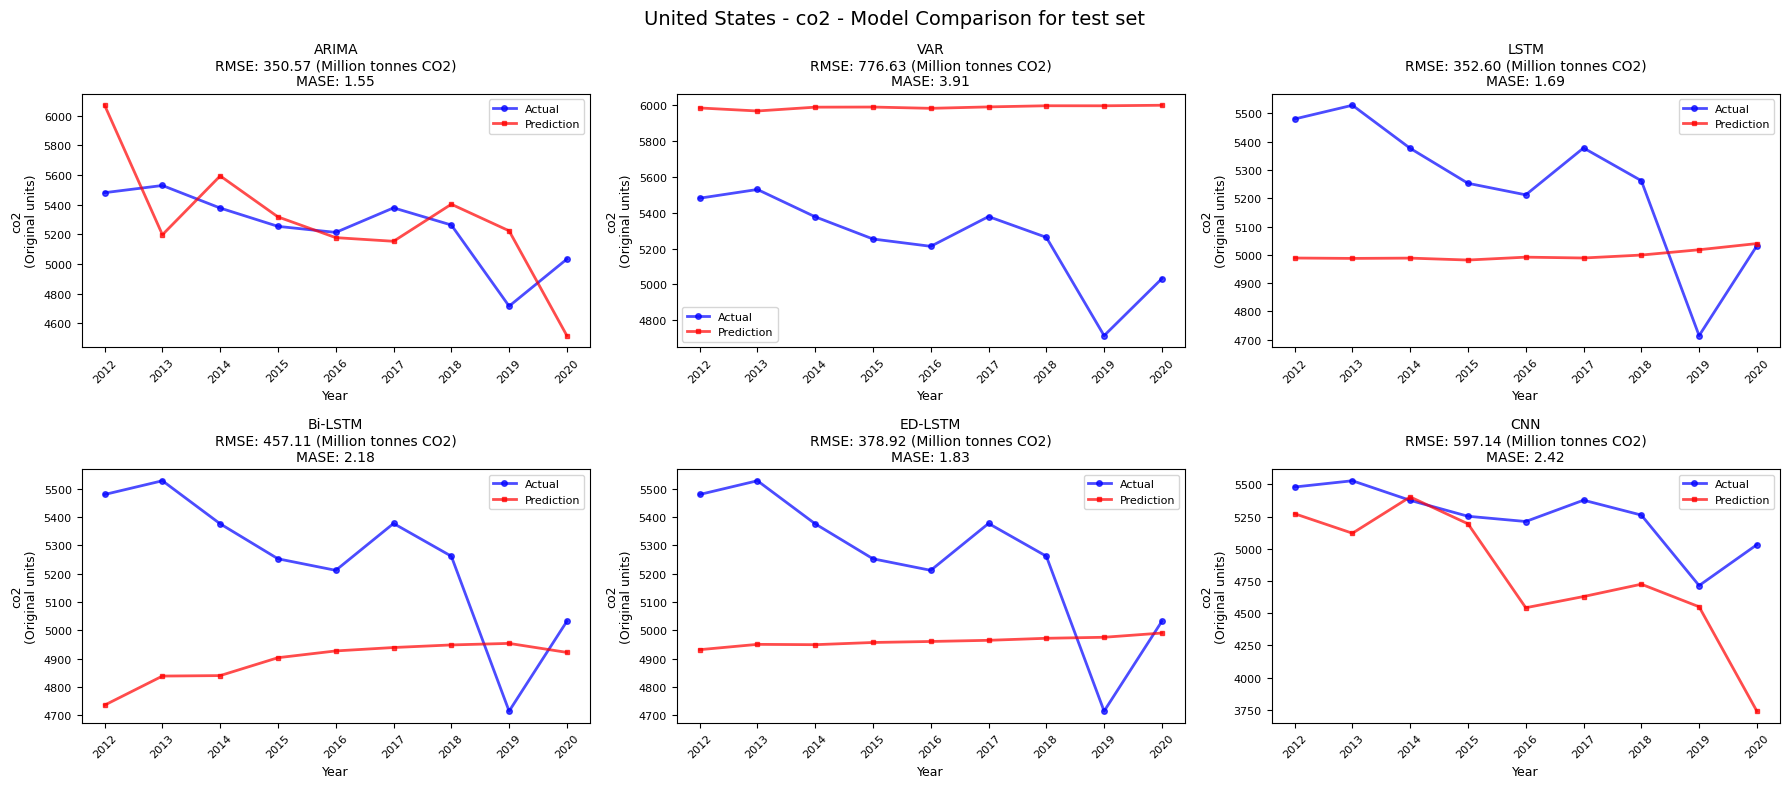

Plotting China - co2
Plot saved: data_export\plots\China_co2_comparison.png


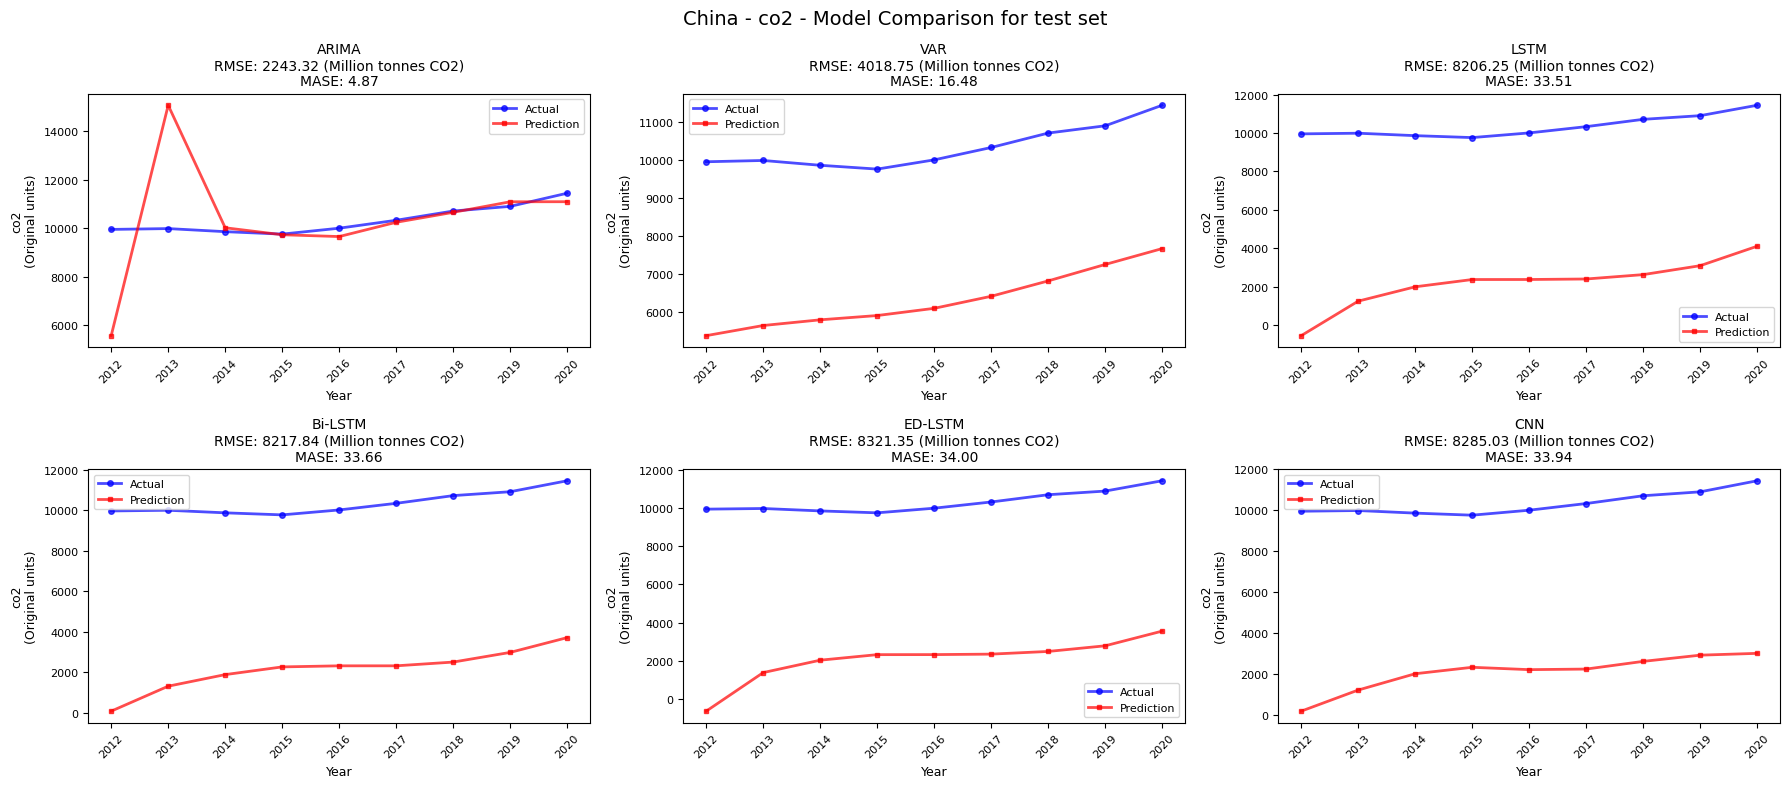

Plotting Germany - co2
Plot saved: data_export\plots\Germany_co2_comparison.png


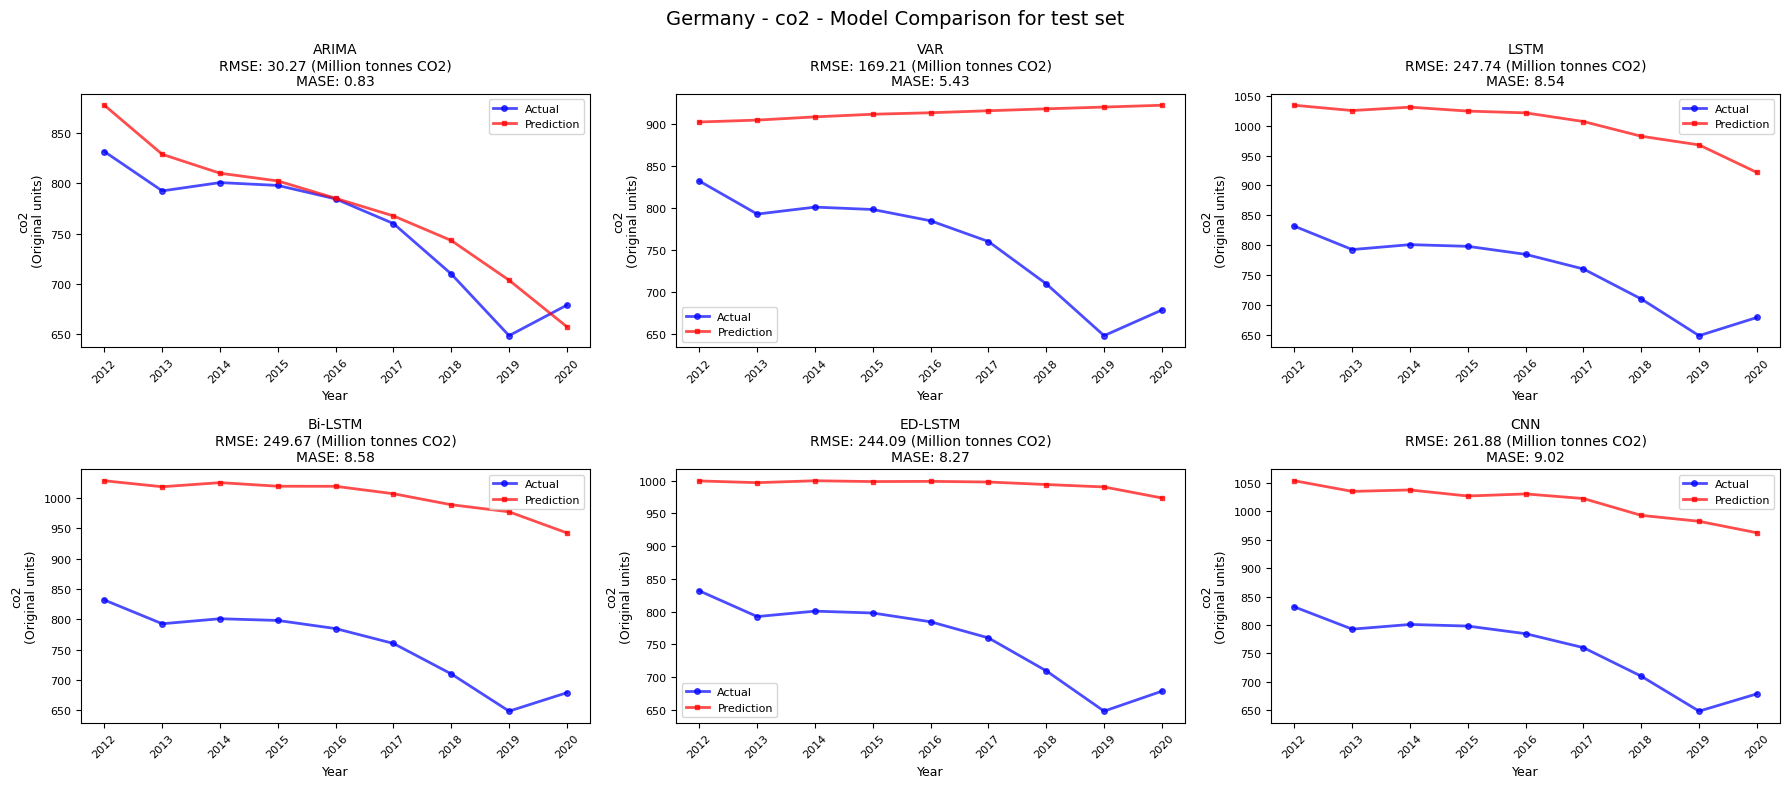

In [30]:
sample_countries = ['United States', 'China', 'Germany']
sample_targets = ['co2']

for target_var in sample_targets:
    if target_var in all_results:
        for country in sample_countries:
            if country in all_results[target_var] and all_results[target_var][country]:
                print(f"Plotting {country} - {target_var}")
                plot_model_comparisons(all_results, target_var, country)

Plotting United States - gdp
Plot saved: data_export\plots\United States_gdp_comparison.png


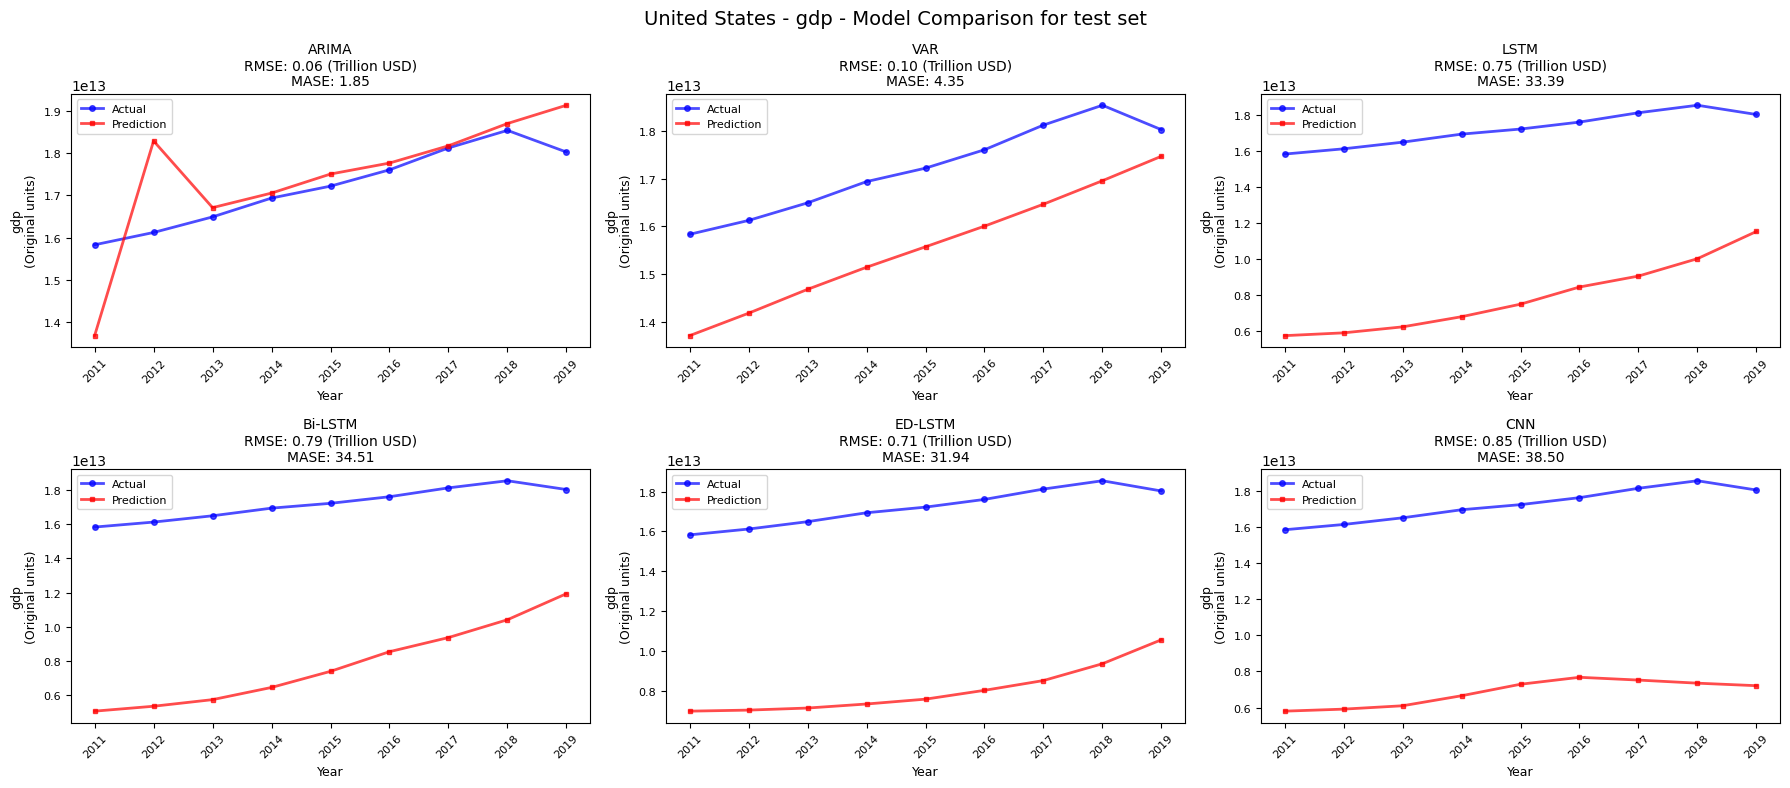

Plotting China - gdp
Plot saved: data_export\plots\China_gdp_comparison.png


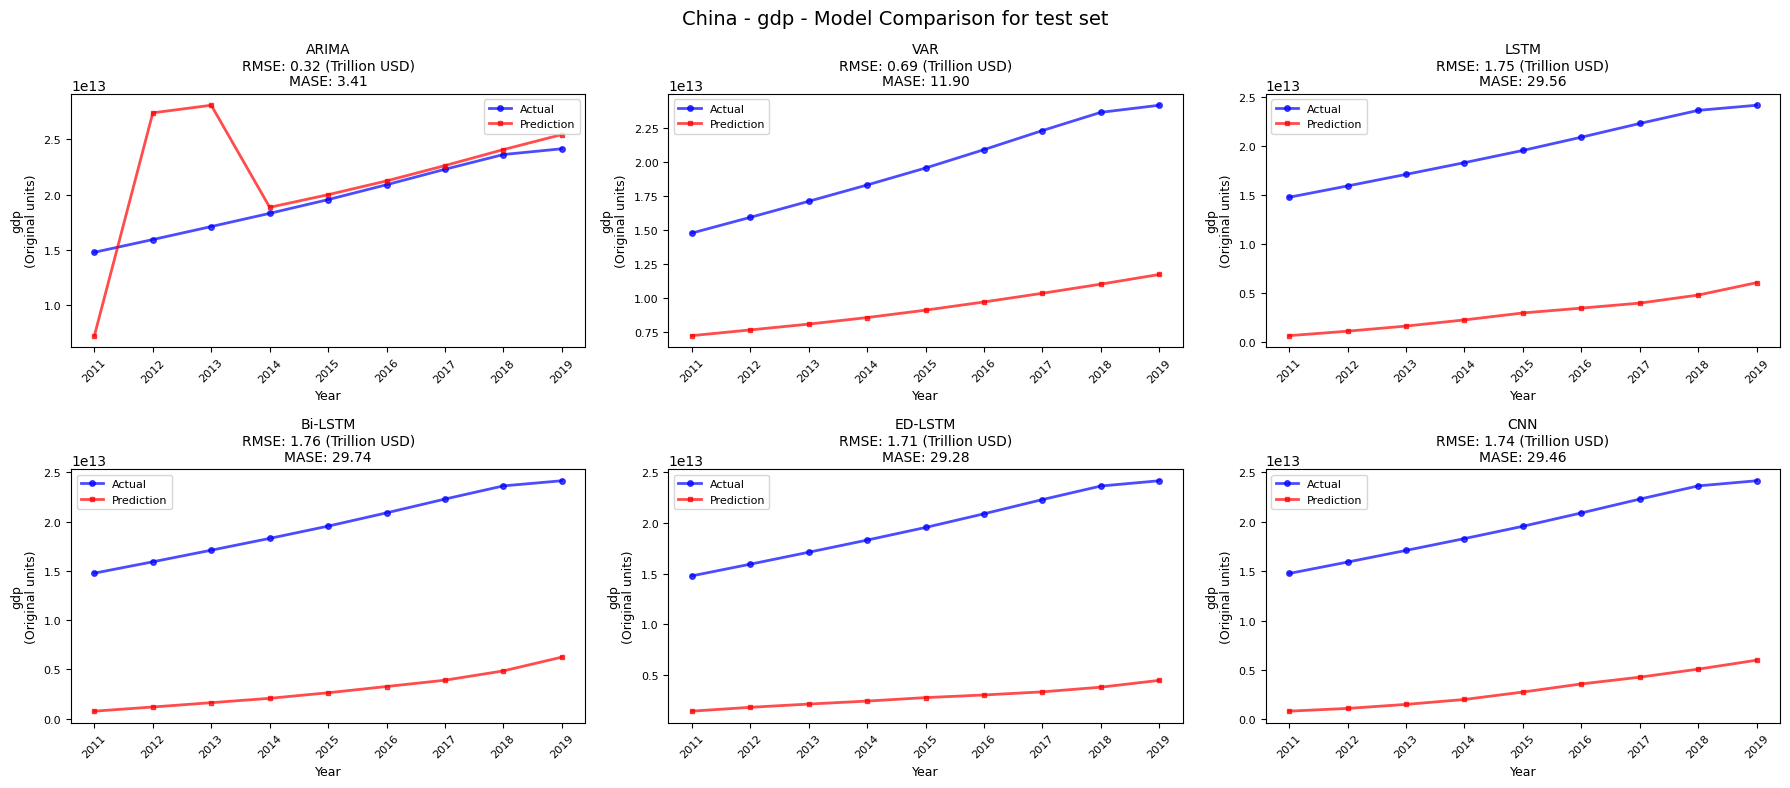

Plotting Australia - gdp
Plot saved: data_export\plots\Australia_gdp_comparison.png


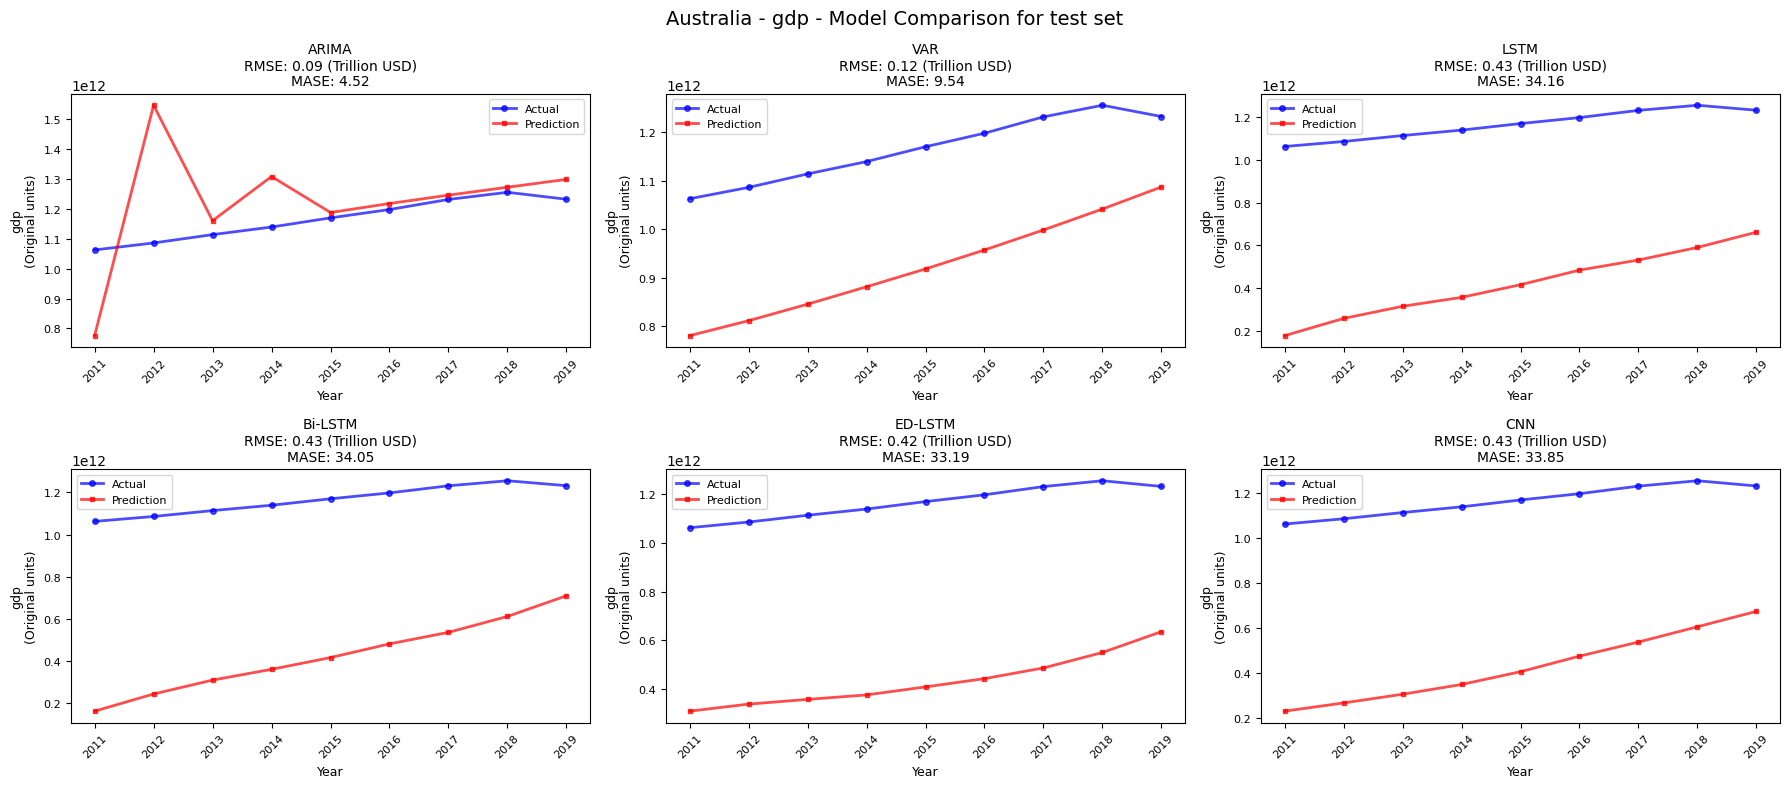

In [31]:
sample_countries = ['United States', 'China', 'Australia']
sample_targets = ['gdp']

for target_var in sample_targets:
    if target_var in all_results:
        for country in sample_countries:
            if country in all_results[target_var] and all_results[target_var][country]:
                print(f"Plotting {country} - {target_var}")
                plot_model_comparisons(all_results, target_var, country)

Plotting United States - primary_energy_consumption
Plot saved: data_export\plots\United States_primary_energy_consumption_comparison.png


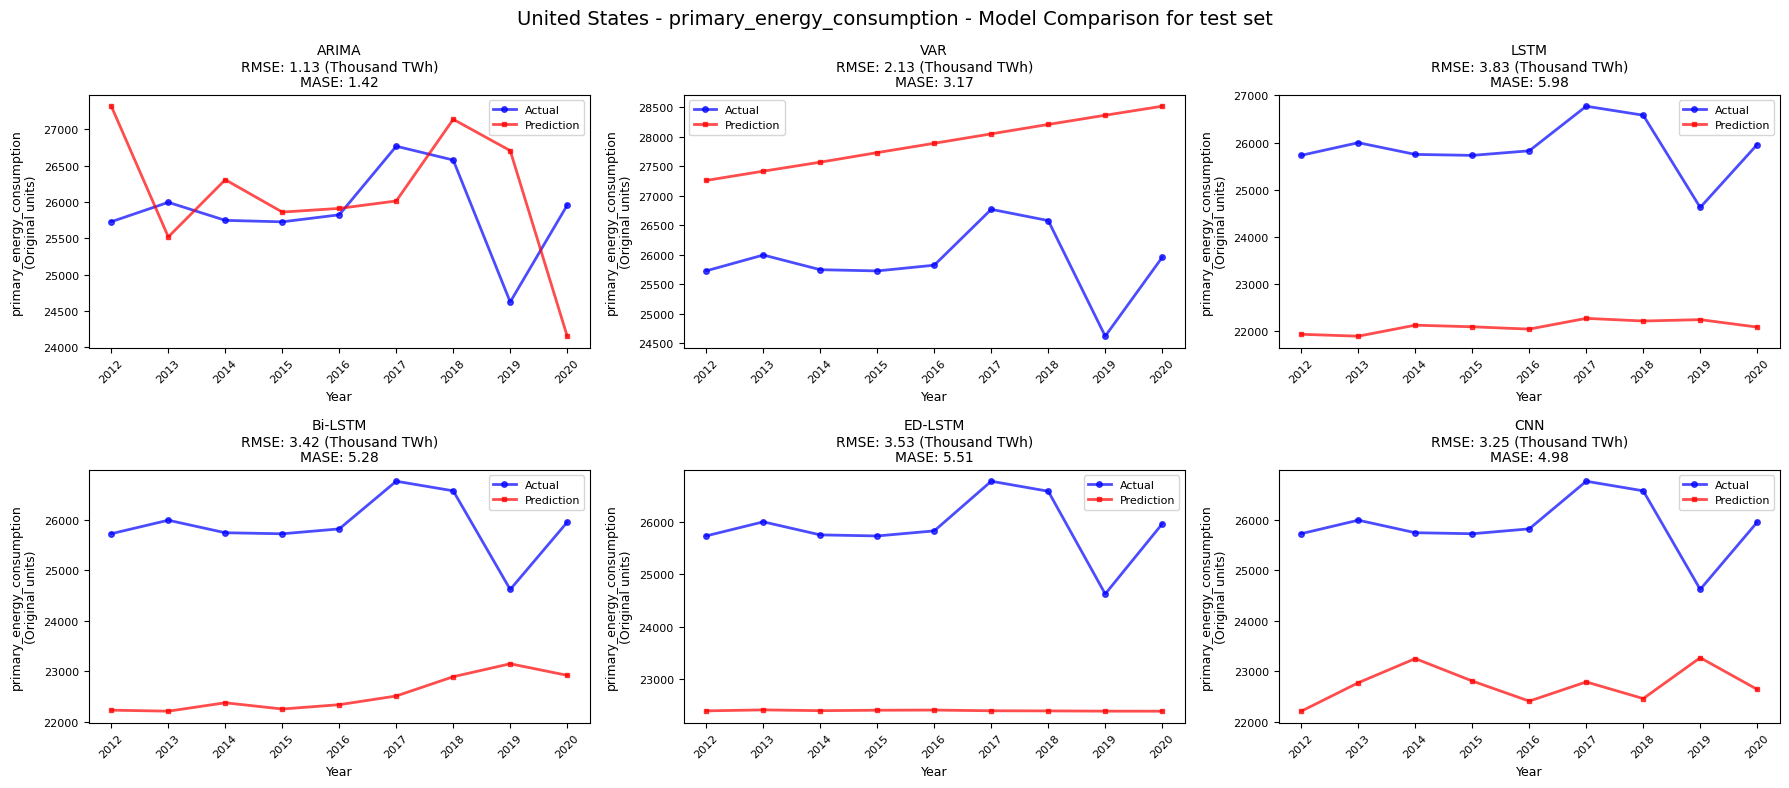

Plotting China - primary_energy_consumption
Plot saved: data_export\plots\China_primary_energy_consumption_comparison.png


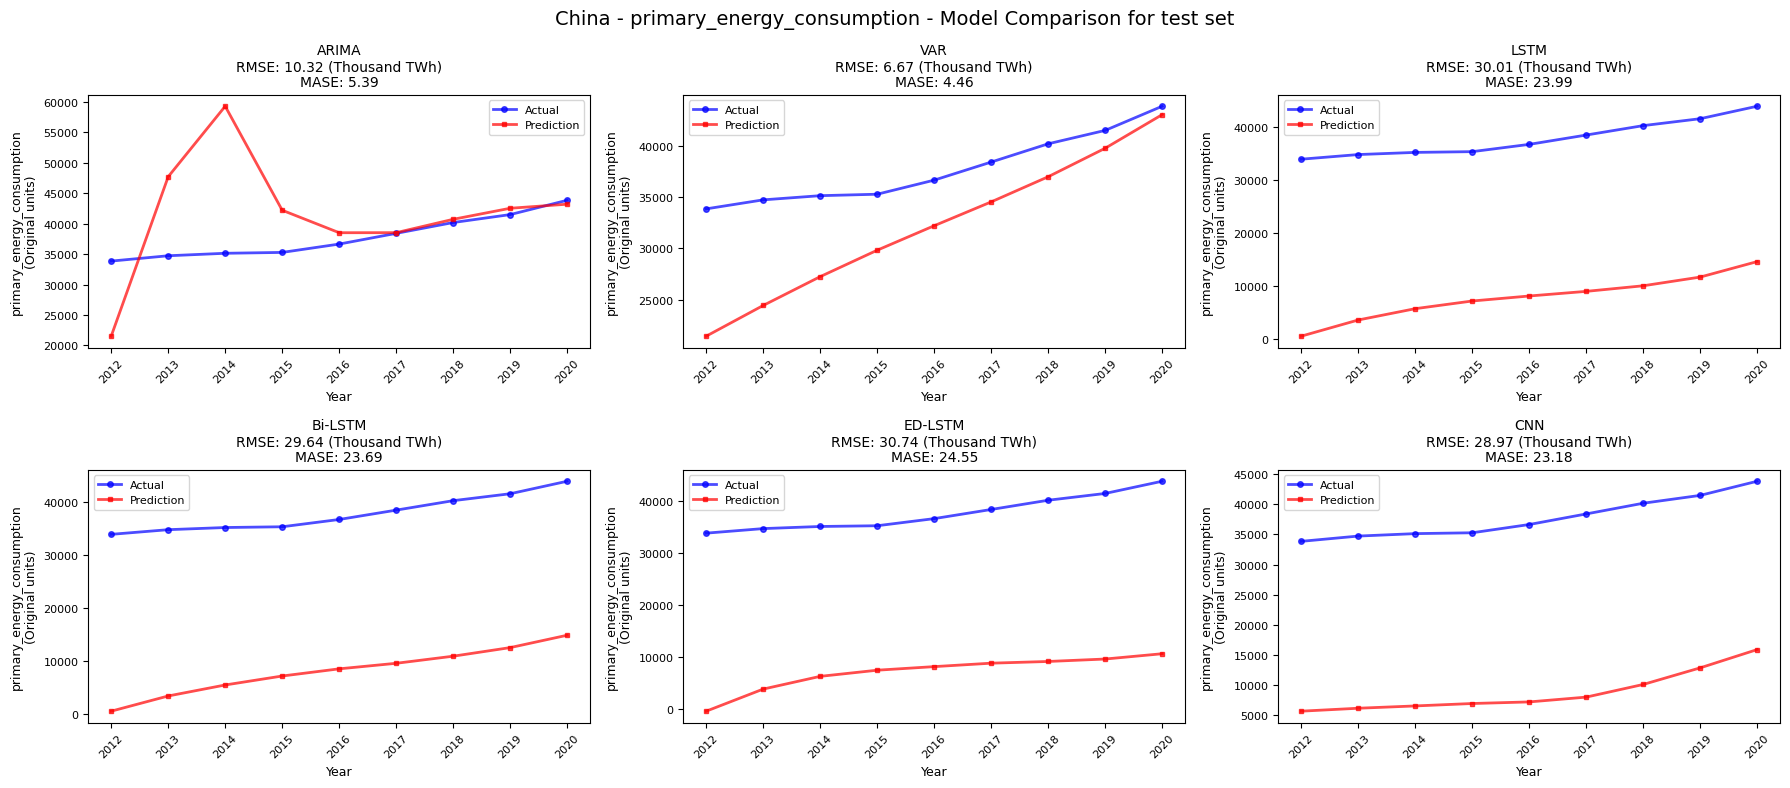

Plotting South Korea - primary_energy_consumption
Plot saved: data_export\plots\South Korea_primary_energy_consumption_comparison.png


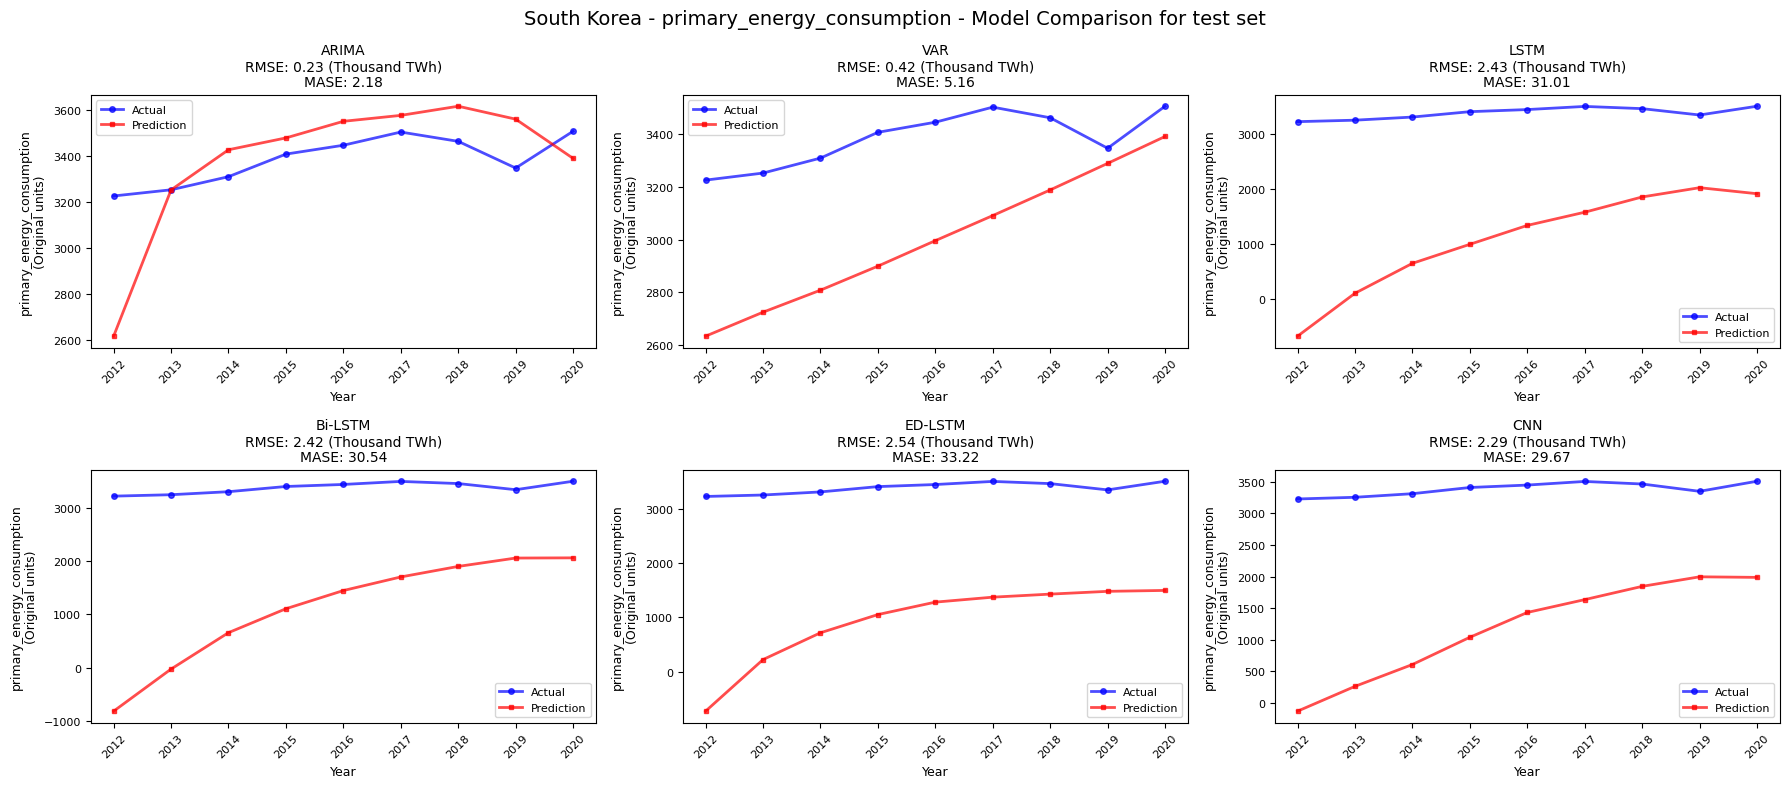

In [32]:
sample_countries = ['United States', 'China', 'South Korea']
sample_targets = ['primary_energy_consumption']

for target_var in sample_targets:
    if target_var in all_results:
        for country in sample_countries:
            if country in all_results[target_var] and all_results[target_var][country]:
                print(f"Plotting {country} - {target_var}")
                plot_model_comparisons(all_results, target_var, country)